In [1]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split, KFold
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc
import numpy as np

if not os.path.isfile('car_price.csv'):
    !wget -O 'car_price.csv' "https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-02-car-price/data.csv"

In [2]:
columns = ["Make", "Model", "Year", "Engine HP", "Engine Cylinders", "Transmission Type", "Vehicle Style", "highway MPG", "city mpg", "MSRP"]

In [3]:
df = pd.read_csv("car_price.csv")
df.head()

,Make,Model,Year,Engine Fuel Type,Engine HP,Engine Cylinders,Transmission Type,Driven_Wheels,Number of Doors,Market Category,Vehicle Size,Vehicle Style,highway MPG,city mpg,Popularity,MSRP
0,BMW,1 Series M,2011,premium unleaded (required),335.0,6.0,MANUAL,rear wheel drive,2.0,"Factory Tuner,Luxury,High-Performance",Compact,Coupe,26,19,3916,46135
1,BMW,1 Series,2011,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,Performance",Compact,Convertible,28,19,3916,40650
2,BMW,1 Series,2011,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,High-Performance",Compact,Coupe,28,20,3916,36350
3,BMW,1 Series,2011,premium unleaded (required),230.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,Performance",Compact,Coupe,28,18,3916,29450
4,BMW,1 Series,2011,premium unleaded (required),230.0,6.0,MANUAL,rear wheel drive,2.0,Luxury,Compact,Convertible,28,18,3916,34500


In [4]:
df = df[columns].copy()
df.head()

,Make,Model,Year,Engine HP,Engine Cylinders,Transmission Type,Vehicle Style,highway MPG,city mpg,MSRP
0,BMW,1 Series M,2011,335.0,6.0,MANUAL,Coupe,26,19,46135
1,BMW,1 Series,2011,300.0,6.0,MANUAL,Convertible,28,19,40650
2,BMW,1 Series,2011,300.0,6.0,MANUAL,Coupe,28,20,36350
3,BMW,1 Series,2011,230.0,6.0,MANUAL,Coupe,28,18,29450
4,BMW,1 Series,2011,230.0,6.0,MANUAL,Convertible,28,18,34500


In [5]:
df.columns = df.columns.str.lower().str.replace(' ', '_')
df.head()

,make,model,year,engine_hp,engine_cylinders,transmission_type,vehicle_style,highway_mpg,city_mpg,msrp
0,BMW,1 Series M,2011,335.0,6.0,MANUAL,Coupe,26,19,46135
1,BMW,1 Series,2011,300.0,6.0,MANUAL,Convertible,28,19,40650
2,BMW,1 Series,2011,300.0,6.0,MANUAL,Coupe,28,20,36350
3,BMW,1 Series,2011,230.0,6.0,MANUAL,Coupe,28,18,29450
4,BMW,1 Series,2011,230.0,6.0,MANUAL,Convertible,28,18,34500


In [6]:
df['above_average'] = (df.msrp >= df.msrp.mean()).astype(int)
del df['msrp']
df['above_average'].value_counts()

0    8645
1    3269
Name: above_average, dtype: int64

In [7]:
columns = list(df.columns)

In [8]:
numerical = list(df.dtypes[df.dtypes != 'object'].index)
numerical.remove('above_average')
categorical = list(df.dtypes[df.dtypes == 'object'].index)

In [9]:
numerical

['year', 'engine_hp', 'engine_cylinders', 'highway_mpg', 'city_mpg']

In [10]:
df = df.fillna(0)
df.isnull().sum()

make                 0
model                0
year                 0
engine_hp            0
engine_cylinders     0
transmission_type    0
vehicle_style        0
highway_mpg          0
city_mpg             0
above_average        0
dtype: int64

## split data

In [11]:
df_full_train, df_test = train_test_split(df, test_size=0.2)
df_train, df_val = train_test_split(df_full_train, test_size=0.25)
df_full_train.shape, df_train.shape, df_val.shape, df_test.shape

y_train = df_train.above_average
y_val = df_val.above_average
y_test = df_test.above_average

del df_train['above_average']
del df_val['above_average']
del df_test['above_average']

## Question 1: ROC AUC feature importance
which hs the highest auc: *engine_hp*

In [12]:
for col in numerical:
    auc_score = roc_auc_score(y_train, df_train[col])
    if auc_score < 0.5:
        auc_score = roc_auc_score(y_train, -df_train[col])
    print("%16s: %.6f" % (col, auc_score))

            year: 0.691473
       engine_hp: 0.910128
engine_cylinders: 0.758304
     highway_mpg: 0.626497
        city_mpg: 0.664628


## Training the model

In [13]:
df_train

,make,model,year,engine_hp,engine_cylinders,transmission_type,vehicle_style,highway_mpg,city_mpg
3682,Mercedes-Benz,E-Class,2015,329.0,6.0,AUTOMATIC,Convertible,29,20
8332,Ford,Ranger,2009,207.0,6.0,MANUAL,Extended Cab Pickup,19,15
3973,Hyundai,Entourage,2007,242.0,6.0,AUTOMATIC,Passenger Minivan,23,16
7165,Lincoln,Navigator,2017,380.0,6.0,AUTOMATIC,4dr SUV,20,15
4793,Ford,Focus,2017,123.0,3.0,MANUAL,Sedan,42,30
...,...,...,...,...,...,...,...,...,...
9801,GMC,Sonoma,2002,120.0,4.0,AUTOMATIC,Regular Cab Pickup,23,17
6700,Lincoln,Mark VIII,1996,280.0,8.0,AUTOMATIC,Coupe,24,16
6379,Pontiac,Le Mans,1992,74.0,4.0,MANUAL,Coupe,34,24
394,Mazda,3,2016,184.0,4.0,AUTOMATIC,Sedan,39,28


In [14]:
dv = DictVectorizer(sparse=False)
train_dicts = df_train.to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val.to_dict(orient='records')
X_val = dv.transform(val_dicts)

model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

y_pred = model.predict_proba(X_val)[:, 1]
y_pred

array([0.08126911, 0.02256945, 0.00375458, ..., 0.65572726, 0.01410892,
       0.04307009])

## whatts the auc
0.978

In [15]:
round(roc_auc_score(y_val, y_pred),3)

0.977

## Question 3: Precision and Recall
Now let's compute precision and recall for our model.

Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
For each threshold, compute precision and recall
Plot them
At which threshold precision and recall curves intersect?

1. 0.28
1. 0.48
1. 0.68
1. 0.88

0.48

In [16]:
def tpr_fpr_pr_dataframe(y_val, y_pred):
    threshold = np.linspace(0,1,101)
    scores = []
    for t in threshold:
        actual_postive = (y_val == 1)
        actual_negative = (y_val == 0)


        predicted_positive = (y_pred >= t)
        predicted_negative = (y_pred < t)

        tn = (predicted_negative & actual_negative).sum()
        tp = (predicted_positive & actual_postive).sum()
        
        fn = (predicted_negative & actual_postive).sum()
        fp = (predicted_positive & actual_negative).sum()

        scores.append((t, tn, tp, fn, fp))

    df_roc = pd.DataFrame(scores, columns=['threshold', 'tn', 'tp', 'fn', 'fp'])
    return df_roc

df_scores = tpr_fpr_pr_dataframe(y_val, y_pred)

df_scores['p'] = df_scores.tp / (df_scores.tp + df_scores.fp)
df_scores['r'] = df_scores.tp / (df_scores.tp + df_scores.fn)
df_scores['f1'] = 2 * ((df_scores.p * df_scores.r)/(df_scores.p + df_scores.r))


df_scores[::10]

,threshold,tn,tp,fn,fp,p,r,f1
0,0.0,0,655,0,1728,0.274864,1.000000,0.431205
10,0.1,1400,643,12,328,0.662204,0.981679,0.790898
20,0.2,1541,626,29,187,0.769988,0.955725,0.852861
30,0.3,1608,606,49,120,0.834711,0.925191,0.877625
40,0.4,1627,583,72,101,0.852339,0.890076,0.870799
50,0.5,1660,555,100,68,0.890851,0.847328,0.868545
60,0.6,1685,519,136,43,0.923488,0.792366,0.852917
70,0.7,1699,484,171,29,0.943470,0.738931,0.828767
80,0.8,1708,434,221,20,0.955947,0.662595,0.782687
90,0.9,1719,344,311,9,0.974504,0.525191,0.682540


In [17]:
df_scores[df_scores.p == df_scores.r]

,threshold,tn,tp,fn,fp,p,r,f1


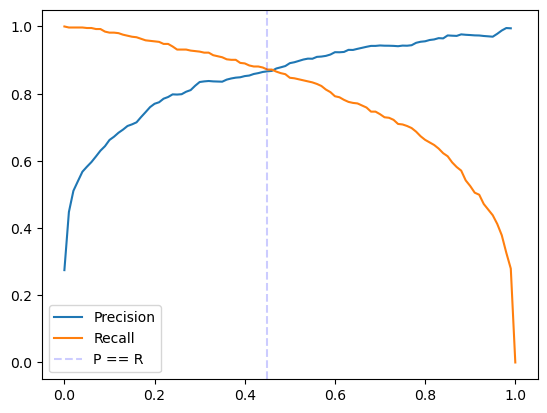

In [18]:
import matplotlib.pyplot as plt

plt.plot(df_scores.threshold, df_scores.p, label="Precision")
plt.plot(df_scores.threshold, df_scores.r, label="Recall")
plt.axvline(x = 0.45, color = 'b', label = 'P == R', linestyle="--", alpha=0.2)
plt.legend()
plt.show()

## Question 4: F1 score
Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both

This is the formula for computing F1:

 f1 = 2 x (PR)/(P+R)

Where 
 is precision and 
 is recall.

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01

At which threshold F1 is maximal? (0.37)

In [19]:
df_scores[df_scores.f1 == df_scores.f1.max()]

,threshold,tn,tp,fn,fp,p,r,f1
32,0.32,1611,604,51,117,0.837725,0.922137,0.877907


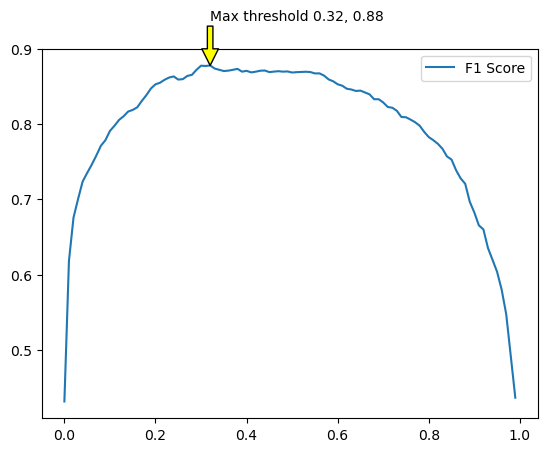

In [20]:
fig = plt.figure()
ax = fig.add_subplot(111)

plt.plot(df_scores.threshold, df_scores.f1, label="F1 Score")
# plt.axvline(x = 0.47, color = 'b', label = 'P == R', linestyle="--")

# maxpoints
xmax, ymax = df_scores[df_scores.f1 == df_scores.f1.max()].threshold.values[0], df_scores[df_scores.f1 == df_scores.f1.max()].f1.values[0]
xmax, ymax

ax.annotate('Max threshold {:.2f}, {:.2f}'.format(xmax, ymax), xy=(xmax, ymax), xytext=(xmax, ymax + 0.06), arrowprops=dict(facecolor='yellow'),)
plt.legend()
plt.show()

## Question 5: 5-Fold CV
Use the KFold class from Scikit-Learn to evaluate our model on 5 different folds:

KFold(n_splits=5, shuffle=True, random_state=1)
Iterate over different folds of df_full_train
Split the data into train and validation
Train the model on train with these parameters: LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
Use AUC to evaluate the model on validation
How large is standard deviation of the scores across different folds?

1. 0.003
2. 0.030
3. 0.090
4. 0.140

In [21]:
scores = []
kfold = KFold(n_splits=5, shuffle=True, random_state=1)
for train_indx, val_indx in kfold.split(df_full_train):
    df_train = df_full_train.iloc[train_indx]
    df_val = df_full_train.iloc[val_indx]
    
    y_train = df_train.above_average
    y_val = df_val.above_average
    
    del  df_train['above_average']
    del  df_val['above_average']
    
    train_dicts = df_train.to_dict(orient='records')
    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(train_dicts)
    val_dicts = df_val.to_dict(orient='records')
    X_val = dv.transform(val_dicts)
   
    
    model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
    model.fit(X_train, y_train)
    
    y_pred = model.predict_proba(X_val)[:, 1]
    
    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)
print("{:.3f} +- {:.3f}".format(np.mean(scores), np.std(scores)))

0.978 +- 0.005


Hyperparameter tuning
which c leads to best mean: 10

In [22]:
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

for C in [0.01, 0.1, 0.5, 10]:
    scores = []

    for train_indx, val_indx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_indx]
        df_val = df_full_train.iloc[val_indx]

        y_train = df_train.above_average
        y_val = df_val.above_average

        del  df_train['above_average']
        del  df_val['above_average']

        train_dicts = df_train.to_dict(orient='records')
        dv = DictVectorizer(sparse=False)
        X_train = dv.fit_transform(train_dicts)
        val_dicts = df_val.to_dict(orient='records')
        X_val = dv.transform(val_dicts)


        model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
        model.fit(X_train, y_train)

        y_pred = model.predict_proba(X_val)[:, 1]

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)
    print("{} - {:.3f} +- {:.3f}".format(C, np.mean(scores), np.std(scores)))

0.01 - 0.951 +- 0.004
0.1 - 0.971 +- 0.003
0.5 - 0.976 +- 0.003
10 - 0.978 +- 0.005
